In [1]:
from IPython.display import clear_output

In [2]:
!pip install pymorphy2 sparse_dot_topn
!python -m nltk.downloader stopwords
!python -m nltk.downloader wordnet

clear_output()

In [3]:
import os
import re

import json
import gzip
import codecs

from itertools import islice, chain, filterfalse, groupby
from collections import Counter, defaultdict, namedtuple
from operator import itemgetter
from functools import partial

import numpy as np
import scipy.sparse as sp
import scipy.stats as ss
import pandas as pd

import lxml.html as lhtml

import lightgbm as lgb
import xgboost as xgb

# from tqdm.notebook import tqdm
from tqdm import tqdm

In [4]:
WORKDIR = '.'

In [5]:
!mkdir -p "{WORKDIR}/data" "{WORKDIR}/models"

In [6]:
def save_array(a, filename: str, sparse: bool = False, **params):
    if sparse and not sp.issparse(a):
        a = sp.csr_matrix(a)
    elif not sparse and sp.issparse(a):
        a = np.asarray(a.todense())

    with open(filename, 'wb') as f_data:
        save = sp.save_npz if sparse else np.save
        return save(f_data, a, **params)


def load_array(filename: str, sparse: bool = False, **params):
    with open(filename, 'rb') as f_data:
        load = sp.load_npz if sparse else np.load
        return load(f_data, **params)

In [7]:
def parse_specializations(s):
    res = s[1:-1].split(',')
    res = map(int, res)
    res = list(res)
    # res = np.asarray(res, dtype=int)
    return res

vacancies_file = os.path.join(WORKDIR, 'data/vacancies_info.csv.gz')

df_all_ids = pd.read_csv(
    vacancies_file,
    index_col='vacancy_id',
    compression='gzip',
)

df_all_ids.loc[df_all_ids['is_train'], 'specializations'] = \
    df_all_ids.loc[df_all_ids['is_train'], 'specializations'].map(parse_specializations)

df_all_ids.head()

/home/poisk/.conda/envs/ml-py37/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,specializations,is_train,area_id,compensation_from,compensation_to,creation_date,currency,employer,employment,work_experience,work_schedule
vacancy_id,,,,,,,,,,,
1,"[242, 256, 302, 324, 358, 440]",True,26,22000.0,24000.0,2019-01-24,RUR,0ce23382345c,full,between1And3,fullDay
2,NaN,False,160,NaN,NaN,2019-07-26,NaN,b9aa259f8724,full,between1And3,fullDay
3,[211],True,1002,NaN,NaN,2019-04-15,NaN,11ecc72a7a76,project,between1And3,fullDay
4,"[389, 412, 437]",True,22,NaN,36000.0,2019-07-12,RUR,e1e424ceb5e4,full,noExperience,fullDay
5,NaN,False,1002,600.0,NaN,2019-01-17,BYR,943fd4a3770a,full,between1And3,fullDay


In [8]:
type_employment = pd.api.types.CategoricalDtype(
    categories=['full', 'project', 'part', 'probation', 'volunteer'],
    ordered=False,
)

type_work_experience = pd.api.types.CategoricalDtype(
    categories=['noExperience', 'between1And3', 'between3And6', 'moreThan6'],
    ordered=True,
)

type_work_schedule = pd.api.types.CategoricalDtype(
    categories=['fullDay', 'shift', 'flexible', 'flyInFlyOut', 'remote'],
    ordered=False,
)

# Ranking

In [9]:
from sklearn.model_selection import train_test_split

mask = df_all_ids['is_train'].values

vacancy_id_train, vacancy_id_valid = train_test_split(
      df_all_ids[mask].index.values,
      test_size=0.3,
      random_state=9872,
)

vacancy_id_test = df_all_ids[~mask].index.values

In [10]:
ranking_valid_file = os.path.join(WORKDIR, 'data/ranking-dataset-train.csv.gz')

df_ranking = pd.read_csv(ranking_valid_file, compression='gzip')
df_ranking = df_ranking[df_ranking['vacancy_id'].isin(set(vacancy_id_valid))]
df_ranking.head()

,vacancy_id,spec_id,counts,min_tfidf,max_tfidf,logreg_score,counts_prob,logreg_employer_weight,rank_counts,rank_counts_prob,rank_logreg_score,target
27,4,437,8,1.0,1.0,0.667514,0.000074,-0.378561,1.0,2.0,1.0,1
28,4,412,4,1.0,1.0,0.308523,0.000245,-0.286753,2.0,1.0,3.0,1
29,4,439,2,1.0,1.0,0.115831,0.000000,-0.430141,4.5,12.5,7.0,0
30,4,416,2,1.0,1.0,0.061783,0.000000,-0.631631,4.5,12.5,9.0,0
31,4,389,2,1.0,1.0,0.543809,0.000036,-0.719683,4.5,3.0,2.0,1


In [11]:
counts = df_ranking.groupby('vacancy_id')['target'].sum() > 0
counts.sum(), counts.shape[0], counts.sum() / counts.shape[0]

(425579, 436898, 0.9740923510750793)

In [12]:
counts[counts == 0].head()

vacancy_id
144    False
673    False
879    False
978    False
988    False
Name: target, dtype: bool

In [13]:
df_ranking['target'].sum() / df_ranking.shape[0]

0.14653840273658933

In [14]:
def create_features_df(df):
    df = pd.merge(
        df,
        df_all_ids[['employer', 'employment', 'work_experience', 'work_schedule']].reset_index(),
        how='left',
        on='vacancy_id', 
    )
    
    df['employment'] = df['employment'].astype(type_employment)
    df['work_experience'] = df['work_experience'].astype(type_work_experience)
    df['work_schedule'] = df['work_schedule'].astype(type_work_schedule)
    
    return df

In [15]:
%%time

df_ranking = create_features_df(df_ranking)

df_ranking.head()

CPU times: user 2.96 s, sys: 2.11 s, total: 5.07 s
Wall time: 5.08 s


,vacancy_id,spec_id,counts,min_tfidf,max_tfidf,logreg_score,counts_prob,logreg_employer_weight,rank_counts,rank_counts_prob,rank_logreg_score,target,employer,employment,work_experience,work_schedule
0,4,437,8,1.0,1.0,0.667514,0.000074,-0.378561,1.0,2.0,1.0,1,e1e424ceb5e4,full,noExperience,fullDay
1,4,412,4,1.0,1.0,0.308523,0.000245,-0.286753,2.0,1.0,3.0,1,e1e424ceb5e4,full,noExperience,fullDay
2,4,439,2,1.0,1.0,0.115831,0.000000,-0.430141,4.5,12.5,7.0,0,e1e424ceb5e4,full,noExperience,fullDay
3,4,416,2,1.0,1.0,0.061783,0.000000,-0.631631,4.5,12.5,9.0,0,e1e424ceb5e4,full,noExperience,fullDay
4,4,389,2,1.0,1.0,0.543809,0.000036,-0.719683,4.5,3.0,2.0,1,e1e424ceb5e4,full,noExperience,fullDay


In [16]:
df_ranking.dtypes

vacancy_id                   int64
spec_id                      int64
counts                       int64
min_tfidf                  float64
max_tfidf                  float64
logreg_score               float64
counts_prob                float64
logreg_employer_weight     float64
rank_counts                float64
rank_counts_prob           float64
rank_logreg_score          float64
target                       int64
employer                    object
employment                category
work_experience           category
work_schedule             category
dtype: object

In [17]:
columns_features = ~df_ranking.columns.isin({'vacancy_id', 'spec_id', 'employer', 'target'})
columns_features = df_ranking.columns[columns_features]
columns_features

Index(['counts', 'min_tfidf', 'max_tfidf', 'logreg_score', 'counts_prob',
       'logreg_employer_weight', 'rank_counts', 'rank_counts_prob',
       'rank_logreg_score', 'employment', 'work_experience', 'work_schedule'],
      dtype='object')

In [18]:
from sklearn.model_selection import GroupShuffleSplit

kf_split = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state=56)
indexes = next(kf_split.split(df_ranking, groups=df_ranking['vacancy_id']))

df_ranking_train = df_ranking.iloc[indexes[0]]
df_ranking_valid = df_ranking.iloc[indexes[1]]

df_ranking_train.shape, df_ranking_valid.shape

((5620052, 16), (2412136, 16))

In [19]:
def count_group_size(labels):
    return [(name, sum(1 for _ in group)) for name, group in groupby(labels)]


group_train = count_group_size(df_ranking_train['vacancy_id'].values)
group_valid = count_group_size(df_ranking_valid['vacancy_id'].values)

dataset_train = lgb.Dataset(
    data=df_ranking_train[columns_features],
    label=df_ranking_train['target'].values,
    group=list(map(itemgetter(1), group_train)),
)

dataset_valid = lgb.Dataset(
    data=df_ranking_valid[columns_features],
    label=df_ranking_valid['target'].values,
    group=list(map(itemgetter(1), group_valid)),
)

In [20]:
def f1score(y_true, y_pred):
    y_true = set(y_true)
    y_pred = set(y_pred)
    
    tp = len(y_true & y_pred)
    precision = tp / len(y_pred)
    recall = tp / len(y_true)
    if precision == 0.0 and recall == 0.0:
        score = 0.0
    else:
        score = 2 * precision * recall / (precision + recall)
    return score


def f1_score_eval(preds, dataset, group, df_ranking, top=3):
    scores = []
    size_min = 0
    
    for j, (vacancy_id, size) in enumerate(group):
        slice_ = slice(size_min, size_min+size)
        
        y_pred = np.argsort(preds[slice_])[:-top-1:-1]
        y_pred = df_ranking['spec_id'].values[slice_][y_pred]
        
        y_true = df_all_ids.loc[vacancy_id, 'specializations']
        
        score = f1score(y_true, y_pred)
        scores.append(score)
        
        size_min += size
        
    scores = np.mean(scores)
    return 'f1score', scores, True


In [21]:
valid = partial(f1_score_eval, group=group_valid, df_ranking=df_ranking_valid, top=3)
valid(df_ranking_valid['logreg_score'], dataset_valid)

('f1score', 0.519448985820009, True)

In [22]:
valid = partial(f1_score_eval, group=group_valid, df_ranking=df_ranking_valid, top=3)
valid(df_ranking_valid['counts'], dataset_valid)

('f1score', 0.47724251308824434, True)

In [23]:
valid = partial(f1_score_eval, group=group_valid, df_ranking=df_ranking_valid, top=3)
valid(df_ranking_valid['counts_prob'], dataset_valid)

('f1score', 0.267808120221716, True)

In [24]:
%%time

from sklearn.model_selection import GroupKFold

params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'objective': 'binary',
    'metric': ['ndcg', ],
    'eval_at': [6, ],
    'random_state': 42,
    'verbose': 1,
}

def split_dataset(df_ranking, n_splits=5):
    kfold = GroupKFold(n_splits=n_splits)
    index = np.arange(df_ranking.shape[0])
    yield from kfold.split(index, groups=df_ranking['vacancy_id'])

valid_eval = partial(f1_score_eval, group=group_valid, df_ranking=df_ranking_valid, top=3)

cv = lgb.cv(
    params,
    dataset_train,
    num_boost_round=500,
    show_stdv=False,
    stratified=False,
    folds=split_dataset(df_ranking_train, n_splits=5),
)

cv = pd.DataFrame(cv)
print(cv.shape)
cv.head()

(500, 2)
CPU times: user 7h 48min 40s, sys: 2min 58s, total: 7h 51min 38s
Wall time: 8min 33s


,ndcg@6-mean,ndcg@6-stdv
0,0.886016,0.001363
1,0.888398,0.001484
2,0.890983,0.001383
3,0.892047,0.001308
4,0.893547,0.001136


ndcg@6-mean    0.905401
ndcg@6-stdv    0.001260
Name: 498, dtype: float64

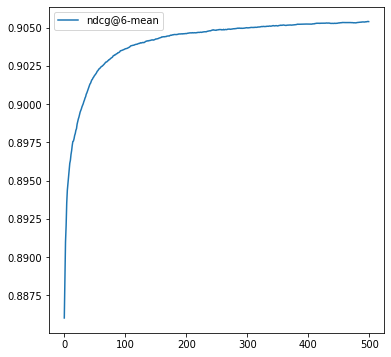

In [25]:
cv.plot(figsize=(6, 6), y=['ndcg@6-mean'])

trees = cv['ndcg@6-mean'].values.argmax()
cv.loc[trees]

In [26]:
model = lgb.train(
    params,
    dataset_train,
    num_boost_round=trees,
    valid_sets=dataset_valid,
#     feval=valid_eval,
#     callbacks=[
#         lgb.reset_parameter(learning_rate=func_learning_rate),
#     ],
)

valid(model.predict(df_ranking_valid[columns_features]), dataset_valid)

[1]	valid_0's ndcg@6: 0.885714
[2]	valid_0's ndcg@6: 0.887667
[3]	valid_0's ndcg@6: 0.890859
[4]	valid_0's ndcg@6: 0.891449
[5]	valid_0's ndcg@6: 0.893002
[6]	valid_0's ndcg@6: 0.893892
[7]	valid_0's ndcg@6: 0.894091
[8]	valid_0's ndcg@6: 0.894718
[9]	valid_0's ndcg@6: 0.895164
[10]	valid_0's ndcg@6: 0.89565
[11]	valid_0's ndcg@6: 0.895705
[12]	valid_0's ndcg@6: 0.896108
[13]	valid_0's ndcg@6: 0.896584
[14]	valid_0's ndcg@6: 0.896811
[15]	valid_0's ndcg@6: 0.897084
[16]	valid_0's ndcg@6: 0.897426
[17]	valid_0's ndcg@6: 0.897526
[18]	valid_0's ndcg@6: 0.897478
[19]	valid_0's ndcg@6: 0.897685
[20]	valid_0's ndcg@6: 0.897621
[21]	valid_0's ndcg@6: 0.897809
[22]	valid_0's ndcg@6: 0.897999
[23]	valid_0's ndcg@6: 0.898227
[24]	valid_0's ndcg@6: 0.898427
[25]	valid_0's ndcg@6: 0.898507
[26]	valid_0's ndcg@6: 0.898863
[27]	valid_0's ndcg@6: 0.898945
[28]	valid_0's ndcg@6: 0.899201
[29]	valid_0's ndcg@6: 0.899321
[30]	valid_0's ndcg@6: 0.899376
[31]	valid_0's ndcg@6: 0.899593
[32]	valid_0's ndc

('f1score', 0.6091488856675398, True)

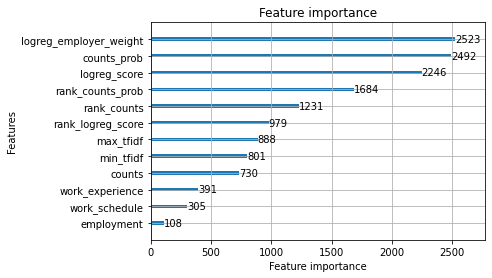

In [27]:
lgb.plot_importance(model)

In [28]:
df_predict_valid = pd.DataFrame(df_ranking_valid[['vacancy_id', 'spec_id']])
df_predict_valid['predict'] = model.predict(df_ranking_valid[columns_features])
df_predict_valid.head()

,vacancy_id,spec_id,predict
43,26,273,3.866354e-01
44,26,245,1.593087e-07
45,26,270,2.118262e-01
46,26,81,2.998475e-01
47,26,142,3.619460e-07


In [29]:
def convert_to_indices_ranks(df_predict, is_train, top=6):
    y_true, y_pred, ranks = [], [], []
    
    for vacancy_id, group in tqdm(df_predict.groupby('vacancy_id'), position=0):
        group.sort_values(by='predict', ascending=False, inplace=True)
        group = group.iloc[:6]
        
        row_indices = group['spec_id'].values
        row_ranks_top = group['predict'].values

        if len(row_indices) < top:
            num = top - len(row_indices)
            row_indices = np.pad(row_indices, (0, num), constant_values=-1, mode='constant')
            row_ranks_top = np.pad(row_ranks_top, (0, num), constant_values=0, mode='constant')
            
        y_pred.append(row_indices)
        ranks.append(row_ranks_top)
        
        if is_train:
            y_true.append(set(df_all_ids.loc[vacancy_id, 'specializations']))
    
    y_true = y_true or None
    y_pred = np.asarray(y_pred)
    ranks = np.asarray(ranks)
        
    return y_true, y_pred, ranks

In [30]:
from hyperopt import fmin, tpe, hp, Trials

space = hp.uniform('threshold', 0.01, 0.99)

y_true, y_pred, ranks_valid = convert_to_indices_ranks(df_predict_valid, is_train=True)

def choose_prediction(indices, ranks, threshold):
    mask = ranks > threshold
    mask[:, 0] = True

    indices_pred = np.where(mask, indices, -1)
    indices_pred = map(lambda e: filter(lambda x: x >= 0, e), indices_pred)
    indices_pred = map(set, indices_pred)
    
    return list(indices_pred)

def objective(threshold):
    indices_pred = choose_prediction(y_pred, ranks_valid, threshold)
    indices_true = y_true
    
    scores = [f1score(*pair) for pair in zip(indices_true, indices_pred)]
    scores = np.asarray(scores)

    return -np.mean(scores)

trials = Trials()
res = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials,
           rstate=np.random.RandomState(4325), verbose=1)
res

  0%|          | 0/131070 [00:00<?, ?it/s]/home/poisk/.conda/envs/ml-py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 131070/131070 [01:49<00:00, 1194.23it/s]


100%|██████████| 100/100 [01:24<00:00,  1.18trial/s, best loss: -0.7102914374097713]


{'threshold': 0.3334744099472366}

In [31]:
threshold_best = res['threshold']
threshold_best

0.3334744099472366

In [32]:
model_name = os.path.join(WORKDIR, 'models/lgbm_ranker_019.model')
model.save_model(model_name)

In [33]:
ranking_test_file = os.path.join(WORKDIR, 'data/ranking-dataset-test.csv.gz')

df_ranking_test = pd.read_csv(ranking_test_file, compression='gzip')
df_ranking_test.head()

,vacancy_id,spec_id,counts,min_tfidf,max_tfidf,logreg_score,counts_prob,logreg_employer_weight,rank_counts,rank_counts_prob,rank_logreg_score
0,2,211,9,0.66391,0.66391,0.401377,0.0,-0.169150,1.0,15.5,1.0
1,2,172,4,0.66391,0.66391,0.037860,0.0,-0.099528,3.0,15.5,8.0
2,2,420,4,0.66391,0.66391,0.027227,0.0,-0.442375,3.0,15.5,9.0
3,2,395,4,0.66391,0.66391,0.052264,0.0,-0.220978,3.0,15.5,6.0
4,2,388,3,0.66391,0.66391,0.006271,0.0,-0.038150,5.5,15.5,16.0


In [34]:
%%time

df_ranking_test = create_features_df(df_ranking_test)

df_ranking_test.head()

CPU times: user 7.39 s, sys: 4.65 s, total: 12 s
Wall time: 12.1 s


,vacancy_id,spec_id,counts,min_tfidf,max_tfidf,logreg_score,counts_prob,logreg_employer_weight,rank_counts,rank_counts_prob,rank_logreg_score,employer,employment,work_experience,work_schedule
0,2,211,9,0.66391,0.66391,0.401377,0.0,-0.169150,1.0,15.5,1.0,b9aa259f8724,full,between1And3,fullDay
1,2,172,4,0.66391,0.66391,0.037860,0.0,-0.099528,3.0,15.5,8.0,b9aa259f8724,full,between1And3,fullDay
2,2,420,4,0.66391,0.66391,0.027227,0.0,-0.442375,3.0,15.5,9.0,b9aa259f8724,full,between1And3,fullDay
3,2,395,4,0.66391,0.66391,0.052264,0.0,-0.220978,3.0,15.5,6.0,b9aa259f8724,full,between1And3,fullDay
4,2,388,3,0.66391,0.66391,0.006271,0.0,-0.038150,5.5,15.5,16.0,b9aa259f8724,full,between1And3,fullDay


In [35]:
assert df_ranking_test['vacancy_id'].nunique() == (~df_all_ids['is_train']).sum()

In [36]:
df_predict_test = pd.DataFrame(df_ranking_test[['vacancy_id', 'spec_id']])
df_predict_test['predict'] = model.predict(df_ranking_test[columns_features])
df_predict_test.head()

,vacancy_id,spec_id,predict
0,2,211,1.298163e-07
1,2,172,1.308540e-07
2,2,420,1.610312e-07
3,2,395,1.291967e-07
4,2,388,8.607717e-08


In [37]:
y_true, y_pred, ranks_test = convert_to_indices_ranks(df_predict_test, is_train=False)

y_pred_all = choose_prediction(y_pred, ranks_test, threshold_best)
y_pred_all = list(map(list, y_pred_all))

df_submission = df_all_ids.loc[~df_all_ids['is_train'], ['specializations']]
df_submission['specializations'] = y_pred_all

submission_id = 19
submission_file = os.path.join(WORKDIR, 'submission_{:03d}.csv.gz').format(submission_id)

df_submission.to_csv(submission_file, index=True, compression='gzip')
df_submission.head()

  0%|          | 0/1456325 [00:00<?, ?it/s]/home/poisk/.conda/envs/ml-py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 1456325/1456325 [19:29<00:00, 1245.58it/s]


,specializations
vacancy_id,
2,[5]
5,[204]
7,[495]
8,"[387, 70, 287]"
10,"[264, 332, 205, 429]"


In [38]:
!zcat "{submission_file}" | head -n5

vacancy_id,specializations
2,[5]
5,[204]
7,[495]
8,"[387, 70, 287]"

gzip: stdout: Broken pipe


In [39]:
!zcat "{WORKDIR}/sample_submission.csv.gz" | head -n5

vacancy_id,specializations
2,"[25, 324, 42]"
5,"[491, 193, 313]"
7,[256]
8,"[287, 70, 83]"

gzip: stdout: Broken pipe
